<a href="https://colab.research.google.com/github/KrittikaDas/consumer-finance-complaints-nlp/blob/main/US_consumer_complaints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [10]:
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import LatentDirichletAllocation

In [5]:
from google.colab import files
uploaded = files.upload()

Saving consumer_complaints.csv to consumer_complaints (1).csv


In [6]:
df = pd.read_csv('consumer_complaints.csv')

<ipython-input-6-99aedf8005e8>:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('consumer_complaints.csv')


In [16]:
print("First 5 rows of the DataFrame:")
print(df.head())
print("\nColumn names:")
print(df.columns)  # Print all column names!
print("\nDataFrame Info:")
print(df.info())

First 5 rows of the DataFrame:
  date_received           product               sub_product  \
0    08/30/2013          Mortgage            Other mortgage   
1    08/30/2013          Mortgage            Other mortgage   
2    08/30/2013  Credit reporting                       NaN   
3    08/30/2013      Student loan  Non-federal student loan   
4    08/30/2013   Debt collection               Credit card   

                                      issue  \
0  Loan modification,collection,foreclosure   
1  Loan servicing, payments, escrow account   
2    Incorrect information on credit report   
3                        Repaying your loan   
4        False statements or representation   

                           sub_issue consumer_complaint_narrative  \
0                                NaN                          NaN   
1                                NaN                          NaN   
2                     Account status                          NaN   
3                 Repaying your

In [17]:
df_insurance = df[df["consumer_complaint_narrative"].str.contains(
    "insurance|auto insurance|home insurance|health insurance|life insurance|policy|claim|coverage",
    case=False,
    na=False
)]

In [18]:
print(f"Number of rows after filtering for 'insurance' keywords: {len(df_insurance)}")

Number of rows after filtering for 'insurance' keywords: 11340


In [19]:
 df_small = df_insurance.dropna(subset=["consumer_complaint_narrative"]).sample(1000, random_state=42)

In [20]:
df_small.to_csv("insurance_complaints_sample.csv", index=False)

In [21]:
print(f"Number of rows after sampling: {len(df_small)}")

Number of rows after sampling: 1000


In [23]:
print("\nSampled DataFrame Info:")
print(df_small.info())
print("\nSampled DataFrame Head:")
print(df_small.head())


Sampled DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 227376 to 291244
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 1000 non-null   object
 1   product                       1000 non-null   object
 2   sub_product                   774 non-null    object
 3   issue                         1000 non-null   object
 4   sub_issue                     402 non-null    object
 5   consumer_complaint_narrative  1000 non-null   object
 6   company_public_response       485 non-null    object
 7   company                       1000 non-null   object
 8   state                         997 non-null    object
 9   zipcode                       997 non-null    object
 10  tags                          186 non-null    object
 11  consumer_consent_provided     1000 non-null   object
 12  submitted_via                 1000 non-null   obj

In [24]:
if len(df_small) > 0:
    def clean_text(text):
        if isinstance(text, str):
            text = text.lower()
            text = re.sub(r'<[^>]*>', '', text)
            text = re.sub(r'https?://\S+|www\.\S+', '', text)
            text = re.sub(r'[^a-zA-Z\s]', '', text)
            text = text.translate(str.maketrans('', '', string.punctuation))
            words = text.split()
            stop_words = set(stopwords.words('english'))
            words = [word for word in words if word not in stop_words]
            lemmatizer = WordNetLemmatizer()
            words = [lemmatizer.lemmatize(word) for word in words if len(word) > 2]
            text = ' '.join(words)
            return text
        else:
            return ''

In [28]:
import nltk


nltk.download('stopwords')
nltk.download('wordnet')


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [29]:
df_small['Cleaned Complaint'] = df_small['consumer_complaint_narrative'].apply(clean_text)
df_small = df_small[df_small['Cleaned Complaint'] != '']

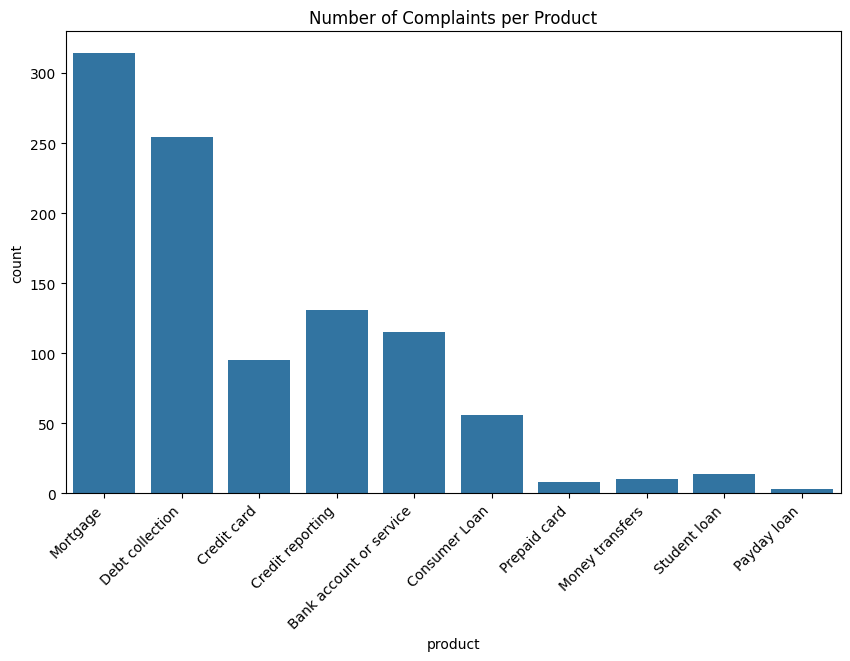

In [31]:
 # 3. Exploratory Data Analysis (EDA)
 # 3.1 Complaint Distribution by Product
plt.figure(figsize=(10, 6))
sns.countplot(x='product', data=df_small)
plt.title('Number of Complaints per Product')
plt.xticks(rotation=45, ha='right')
plt.show()

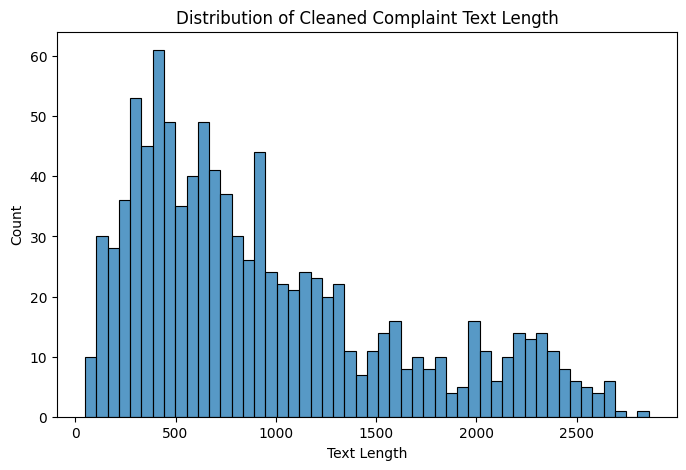

In [33]:
# 3.2 Text Length Analysis
df_small['Text Length'] = df_small['Cleaned Complaint'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(df_small['Text Length'], bins=50)
plt.title('Distribution of Cleaned Complaint Text Length')
plt.show()

In [34]:
# 3.3 Word Frequency
vectorizer = CountVectorizer(max_features=20)
X = vectorizer.fit_transform(df_small['Cleaned Complaint'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
top_words = word_freq.sum().sort_values(ascending=False).head(10)
print("\nTop 10 Words:")
print(top_words)


Top 10 Words:
xxxx        11716
account      1632
credit       1474
payment      1336
loan         1070
would        1025
bank         1007
xxxxxxxx      976
mortgage      841
company       833
dtype: int64


In [35]:
# 4. Sentiment Analysis
# 4.1 Sentiment Labeling (Simplified)
df_small['Sentiment'] = df_small['consumer_disputed?'].apply(lambda x: 'Negative' if x == 'Yes' else 'Positive')
df_small['Sentiment'] = df_small['Sentiment'].fillna('Neutral')

In [36]:
 # 4.2 Text Vectorization (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df_small['Cleaned Complaint'])
y = df_small['Sentiment']

In [37]:
 # 4.3 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

  # 4.4 Model Training (Logistic Regression)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.02      0.04        53
    Positive       0.74      1.00      0.85       147

    accuracy                           0.74       200
   macro avg       0.87      0.51      0.44       200
weighted avg       0.81      0.74      0.63       200



In [38]:
 # Topic Modeling
    # LDA
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X_tfidf)

LatentDirichletAllocation(n_components=5, random_state=42)

In [39]:
def display_topics(model, feature_names, num_top_words=10):
        for topic_idx, topic in enumerate(model.components_):
            print(f"Topic {topic_idx}:")
            print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [40]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nLDA Topics:")
display_topics(lda_model, tfidf_feature_names)


LDA Topics:
Topic 0:
caliber hsbc infiniti ltv phh coop fay capitalone bond quicken
Topic 1:
xxxx account credit payment debt loan bank xxxxxxxx company insurance
Topic 2:
scottrade farm target becu cps citigroup tcf claimcould shipper mutual
Topic 3:
glass pinnacle pal bessemer mccarthy supplier nycb marvel mold wolff
Topic 4:
rmc certegy eoscca awa telecheck intercepted ebay mariner convergence zakheim
